# Calisthenics AI Personal Trainer
## Training ML-Models for Handstand, Front Lever & Planche
***

### Pre-processing

In [136]:
# Importing Modules
import tensorflow as tf
import numpy as np
import pandas as pd 
import os
import csv
import tqdm 
import sys
import random
import shutil
import tempfile
import cv2

# Importing MoveNet
movenet_path = os.path.join(os.getcwd(), 'TF-Movenet/examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(movenet_path)

# Load MoveNet Thunder model and utility classes/functions
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('./TF-Movenet/movenet_thunder')

In [137]:
# Runs detection on an input image

def detect(input_tensor, inference_count=3):
    
    movenet.detect(input_tensor.numpy(), reset_crop_region=True)
    
    for _ in range(inference_count - 1):
        detection = movenet.detect(input_tensor.numpy(), 
                                reset_crop_region=False)
    
    return detection

In [138]:
# Draw the detection result on top of the image.
def draw_prediction_on_image(image, person):
  image_np = utils.visualize(image, [person])
  return image_np

# Draw the pose result on top of a white box
def draw_pose(image, person):
  # create a numpy array filled with 255 (white)
  image = np.full(image.shape, 255, dtype=np.uint8)

  # set the values within the box to 255 (white)
  image[1:-1, 1:-1] = 255

  image_np = utils.visualize(image, [person])
  return image_np

In [139]:
class MoveNetPreprocessor(object):
 
  def __init__(self, images_in_folder, images_out_folder, csvs_out_path):
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):

    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)
 
      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0
 
        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape
          
          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path + '. Image isn\'t in RGB format.')
            continue

          person = detect(image)
          
          # Save landmarks if all landmarks were detected
          min_landmark_score = min([keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path + '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_pose(image.numpy().astype(np.uint8), person)
        
          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
        
          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(np.str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))
      
    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)
 
    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

In [140]:
# Test Movenet Pose Estimation
image = tf.io.read_file('/Users/rahul/Documents/Calisthenics-App/Input/Handstand/Bad/1.jpeg')
image = tf.io.decode_jpeg(image)
person = detect(image)
_ = draw_prediction_on_image(image.numpy(), person)

_ = draw_pose(image.numpy(), person)

### Training

In [141]:
import csv
import pandas as pd
import itertools

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

In [142]:
# TODO: Set/Check Path/File Variables Before Running
DATASET_IN = "./Input/Planche/"
DATASET_OUT = "./Input/Split-Planche/"
OUTPUT_DIR = "./TF-Models/Planche/Data/"
CLASSIFIER = "./TF-Models/Planche/Planche-Classifier.tflite"
LABELS = "./TF-Models/Planche/Planche-Labels.txt"

In [143]:
# Split Directory into Train and Test Images
def split_into_train_test(images_origin, images_dest, test_split):
    _, dirs, _ = next(os.walk(images_origin))

    TRAIN_DIR = os.path.join(images_dest, 'train')
    TEST_DIR = os.path.join(images_dest, 'test')
    os.makedirs(TRAIN_DIR, exist_ok=True)
    os.makedirs(TEST_DIR, exist_ok=True)

    for dir in dirs:
        # Get all filenames for this dir, filtered by filetype
        filenames = os.listdir(os.path.join(images_origin, dir))
        filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
            f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]

        # Shuffle the files, deterministically
        filenames.sort()
        random.seed(42)
        random.shuffle(filenames)

        # Divide them into train/test dirs
        os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
        os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
        test_count = int(len(filenames) * test_split)
        for i, file in enumerate(filenames):
            if i < test_count:
                destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
            else:
                destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
            shutil.copyfile(file, destination)

        print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')

    print(f'Your split dataset is in "{images_dest}"')

In [144]:
# Splitting the Dataset
dataset_in = DATASET_IN
dataset_out = DATASET_OUT
split_into_train_test(dataset_in, dataset_out, test_split=0.2)
IMAGES_ROOT = dataset_out

output_dir = OUTPUT_DIR

Moved 20 of 102 from class "Perfect" into test.
Moved 21 of 108 from class "Bad" into test.
Moved 12 of 60 from class "Good" into test.
Moved 39 of 198 from class "Average" into test.
Your split dataset is in "./Input/Split-Planche/"


In [145]:
# Preprocess Train Folder
images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
images_out_train_folder = output_dir + '/images_out_train'
csvs_out_train_path = output_dir + '/train_data.csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_train_folder,
    images_out_folder=images_out_train_folder,
    csvs_out_path=csvs_out_train_path,
)
preprocessor.process(per_pose_class_limit=None)

Preprocessing Average
  0%|          | 0/159 [00:00<?, ?it/s]/Users/rahul/Documents/Calisthenics-App/venv/lib/python3.7/site-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 159/159 [01:20<00:00,  1.96it/s]
Preprocessing Bad
100%|██████████| 87/87 [00:38<00:00,  2.27it/s]
Preprocessing Good
100%|██████████| 48/48 [00:16<00:00,  2.91it/s]
Preprocessing Perfect
100%|██████████| 82/82 [00:28<00:00,  2.89it/s]


Skipped ./Input/Split-Planche/train/Average/10.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Average/190.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Average/8.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Average/85.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Average/86.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Average/9.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Bad/32.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Bad/33.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Good/1.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Good/3.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Good/36.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Good/49.jpeg. No

In [146]:
# Preprocess Test Folder
images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
images_out_test_folder = output_dir + '/images_out_test'
csvs_out_test_path = output_dir + '/test_data.csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_test_folder,
    images_out_folder=images_out_test_folder,
    csvs_out_path=csvs_out_test_path,
)
preprocessor.process(per_pose_class_limit=None)

Preprocessing Average
  0%|          | 0/39 [00:00<?, ?it/s]/Users/rahul/Documents/Calisthenics-App/venv/lib/python3.7/site-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 39/39 [00:16<00:00,  2.43it/s]
Preprocessing Bad
100%|██████████| 21/21 [00:07<00:00,  2.98it/s]
Preprocessing Good
100%|██████████| 12/12 [00:05<00:00,  2.13it/s]
Preprocessing Perfect
100%|██████████| 20/20 [00:08<00:00,  2.26it/s]

Skipped ./Input/Split-Planche/test/Average/7.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/test/Average/87.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/test/Good/4.jpeg. No pose was confidentlly detected.


In [147]:
# Loads a CSV Created by MoveNetPreprocessor
def load_pose_landmarks(csv_path):
    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    classes = df_to_process.pop('class_name').unique()

    # Extract the labels
    y = df_to_process.pop('class_no')

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

In [148]:
# Calculates Center Point of Two Given Landmarks
def get_center_point(landmarks, left_bodypart, right_bodypart):
  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center

In [149]:
# Calculates Pose Size 
# Maximum of two values 
# - Torso size multiplied by `torso_size_multiplier` 
# - Maximum distance from pose center to any pose landmark
def get_pose_size(landmarks, torso_size_multiplier=2.5):
  
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER, BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)

    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new, [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0, name="dist_to_pose_center")

    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size

In [150]:
# Normalizing Landmarks by Moving Pose Center to (0,0) and Scaling to Constant Size
def normalize_pose_landmarks(landmarks):
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)

    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks

In [151]:
# Converts Input Landmarks into Pose Embedding
def landmarks_to_embedding(landmarks_and_scores):

  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

In [152]:
def preprocess_data(X_train):
    processed_X_train = []
    for i in range(X_train.shape[0]):
        embedding = landmarks_to_embedding(tf.reshape(tf.convert_to_tensor(X_train.iloc[i]), (1, 51)))
        processed_X_train.append(tf.reshape(embedding, (34)))
    return tf.convert_to_tensor(processed_X_train)

In [153]:
# Load the train data
X, y, class_names, df = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

In [154]:
processed_X_train = preprocess_data(X_train)
processed_X_val =  preprocess_data(X_val)
processed_X_test = preprocess_data(X_test)

inputs = tf.keras.Input(shape=(34))
layer = keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
print(model.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_15 (Dense)            (None, 128)               4480      
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 4)                 260       
                                                                 
Total params: 12,996
Trainable params: 12,996
Non-trainable

In [155]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest validation accuracy.
checkpoint_path = "TF-Models/weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(processed_X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(processed_X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
11/20 [===============>..............] - ETA: 0s - loss: 1.3493 - accuracy: 0.2898 
Epoch 1: val_accuracy improved from -inf to 0.63636, saving model to TF-Models/weights.best.hdf5
20/20 [==============================] - 2s 25ms/step - loss: 1.3283 - accuracy: 0.3388 - val_loss: 1.2061 - val_accuracy: 0.6364
Epoch 2/200
18/20 [==========================>...] - ETA: 0s - loss: 1.2541 - accuracy: 0.4375
Epoch 2: val_accuracy did not improve from 0.63636
20/20 [==============================] - 0s 6ms/step - loss: 1.2500 - accuracy: 0.4332 - val_loss: 1.0927 - val_accuracy: 0.6000
Epoch 3/200
16/20 [=======================>......] - ETA: 0s - loss: 1.1712 - accuracy: 0.4570
Epoch 3: val_accuracy improved from 0.63636 to 0.65455, saving model to TF-Models/weights.best.hdf5
20/20 [==============================] - 0s 8ms/step - loss: 1.1740 - accuracy: 0.4593 - val_loss: 0.9920 - val_accuracy: 0.6545
Epoch 4/200
17/20 [========================>.....] - ETA: 0s - loss: 1.1086 - 

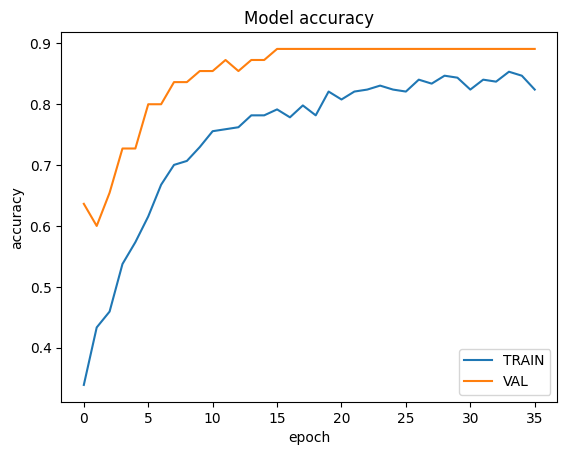

In [156]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [157]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(processed_X_test, y_test)

3/3 [==============================] - 0s 4ms/step - loss: 0.3207 - accuracy: 0.8427


#### Confusion Matrix

3/3 [==============================] - 0s 4ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

     Average       0.97      0.92      0.94        37
         Bad       1.00      1.00      1.00        21
        Good       0.50      0.09      0.15        11
     Perfect       0.61      0.95      0.75        20

    accuracy                           0.84        89
   macro avg       0.77      0.74      0.71        89
weighted avg       0.84      0.84      0.82        89



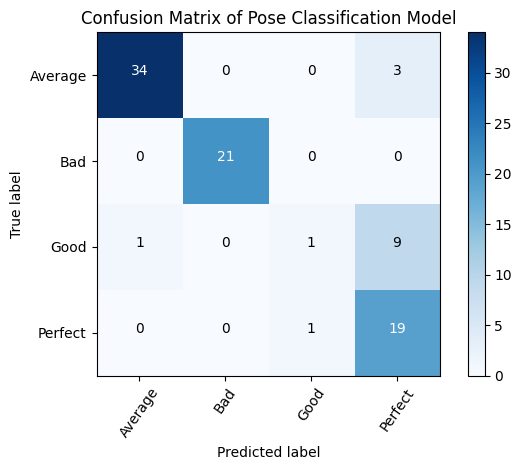

In [158]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(processed_X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [159]:
# Convert pose classification model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open(CLASSIFIER, 'wb') as f:
  f.write(tflite_model)

with open(LABELS, 'w') as f:
  f.write('\n'.join(class_names))

INFO:tensorflow:Assets written to: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpalgcwh8h/assets


INFO:tensorflow:Assets written to: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpalgcwh8h/assets


Model size: 16KB


2023-03-01 20:10:11.609504: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-01 20:10:11.610103: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-01 20:10:11.612469: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpalgcwh8h
2023-03-01 20:10:11.614699: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-01 20:10:11.614718: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpalgcwh8h
2023-03-01 20:10:11.630709: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-01 20:10:11.786549: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpalgcwh8h
2023-03-

In [160]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.array(X[i: i + 1]).astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, processed_X_test, y_test))

Accuracy of TFLite model: 0.8426966292134831
